In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler

# Save the figure
plot_dir = 'feature_analysis/plots'
os.makedirs(plot_dir, exist_ok=True)

# Paths to the prepped data files
base_path = 'daily_data/'
x_train_path = base_path + 'X_train.csv'
x_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
x_train = pd.read_csv(x_train_path)
x_test = pd.read_csv(x_test_path)
y_train_df = pd.read_csv(y_train_path)
y_test_df = pd.read_csv(y_test_path)

# Convert to Series
y_train = y_train_df.iloc[:, 0] if y_train_df.shape[1] == 1 else y_train_df
y_test = y_test_df.iloc[:, 0] if y_test_df.shape[1] == 1 else y_test_df

# Exclude non-numeric columns from scaling
non_numeric_cols = x_train.select_dtypes(exclude=[np.number]).columns
x_train_numeric = x_train.drop(columns=non_numeric_cols)
x_test_numeric = x_test.drop(columns=non_numeric_cols)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
x_train_imputed = imputer.fit_transform(x_train_numeric)
x_test_imputed = imputer.transform(x_test_numeric)

# We want to use MinMaxScaler
scaler = MinMaxScaler()

# Scale 'X' features
x_train_scaled = scaler.fit_transform(x_train_imputed)
x_test_scaled = scaler.transform(x_test_imputed)

# Convert scaled arrays back to DataFrames and add non-numeric columns back
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train_numeric.columns)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test_numeric.columns)

# Add the non-numeric columns back
x_train_scaled_df[non_numeric_cols] = x_train[non_numeric_cols].reset_index(drop=True)
x_test_scaled_df[non_numeric_cols] = x_test[non_numeric_cols].reset_index(drop=True)

# Scale 'y' if necessary
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).flatten()

Feature ranking:
1. feature sma_30 (0.675229379363351)
2. feature open (0.32281567367243147)
3. feature rsi (0.0009040446339742431)
4. feature macd (0.0002301321334160652)
5. feature volume (0.00014721772092081035)
6. feature spy_close (0.00010722034787558138)
7. feature retail_sales_monthly (7.900863124670852e-05)
8. feature spy_volume (7.003980398518858e-05)
9. feature gld_close (6.79247878725962e-05)
10. feature dia_volume (5.771027924241601e-05)
11. feature dia_close (5.312645170100912e-05)
12. feature treasury_yield_daily (4.9345098028945797e-05)
13. feature gld_volume (4.6891528303276135e-05)
14. feature value (4.5160085835219704e-05)
15. feature federal_funds_rate_daily (2.3678992369397065e-05)
16. feature durables_monthly (1.7063295797918016e-05)
17. feature cpi_monthly (9.608554715970236e-06)
18. feature classification_numerical (8.556277815023303e-06)
19. feature unemployment_monthly (8.469151354275297e-06)
20. feature nonfarm_payroll_monthly (7.97875287842099e-06)
21. featur

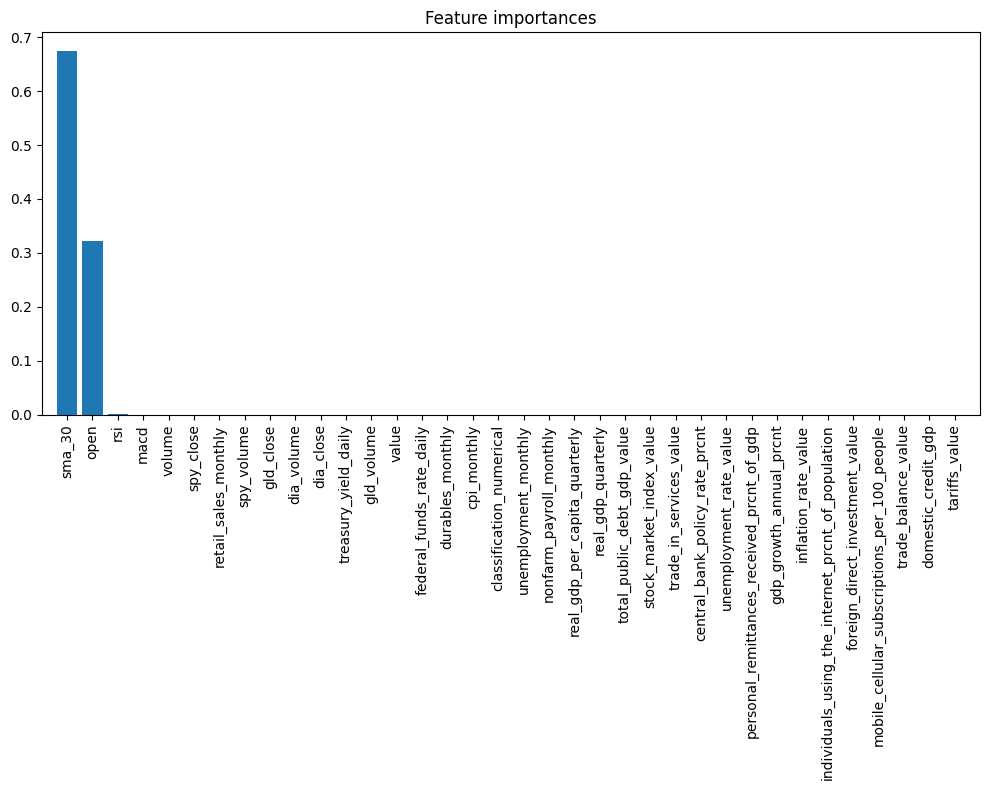

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import os

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train_scaled, y_train_scaled)

# Extract and sort the feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Feature ranking:")
for f in range(len(x_train_numeric.columns)):
    print(f"{f + 1}. feature {x_train_numeric.columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(len(x_train_numeric.columns)), importances[indices], align="center")
plt.xticks(range(len(x_train_numeric.columns)), x_train_numeric.columns[indices], rotation=90)
plt.xlim([-1, len(x_train_numeric.columns)])
plt.tight_layout()  # Adjusts subplots to fit into the figure area.
plot_path = os.path.join(plot_dir, 'feature_importances.png')
plt.savefig(plot_path)
plt.show()

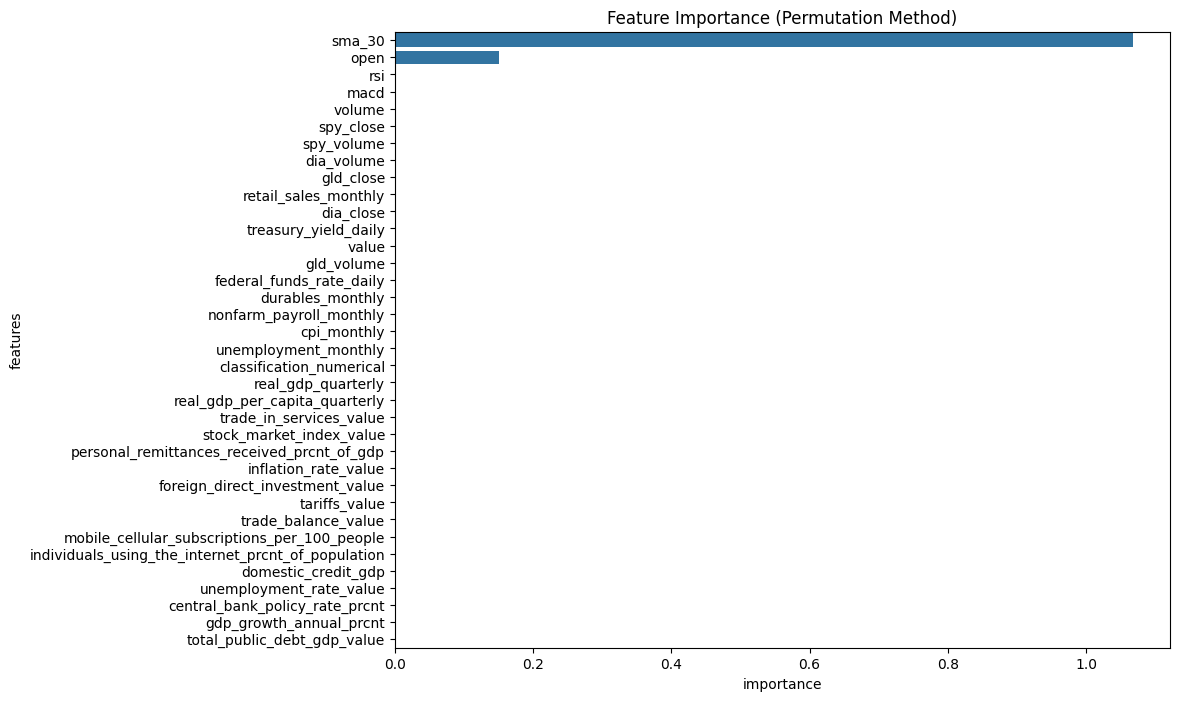

In [7]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
results = permutation_importance(model, x_train_scaled, y_train_scaled, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importance scores
importance_scores = results.importances_mean

# Map the scores to the feature names
feature_importances_perm = pd.DataFrame({'features': x_train_numeric.columns, 'importance': importance_scores})
feature_importances_perm.sort_values(by='importance', ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='features', data=feature_importances_perm)
plt.title('Feature Importance (Permutation Method)')
# Save the figure
plot_path = os.path.join(plot_dir, 'permutation_feature_importances.png')
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(plot_path)
plt.show()


# SHAP

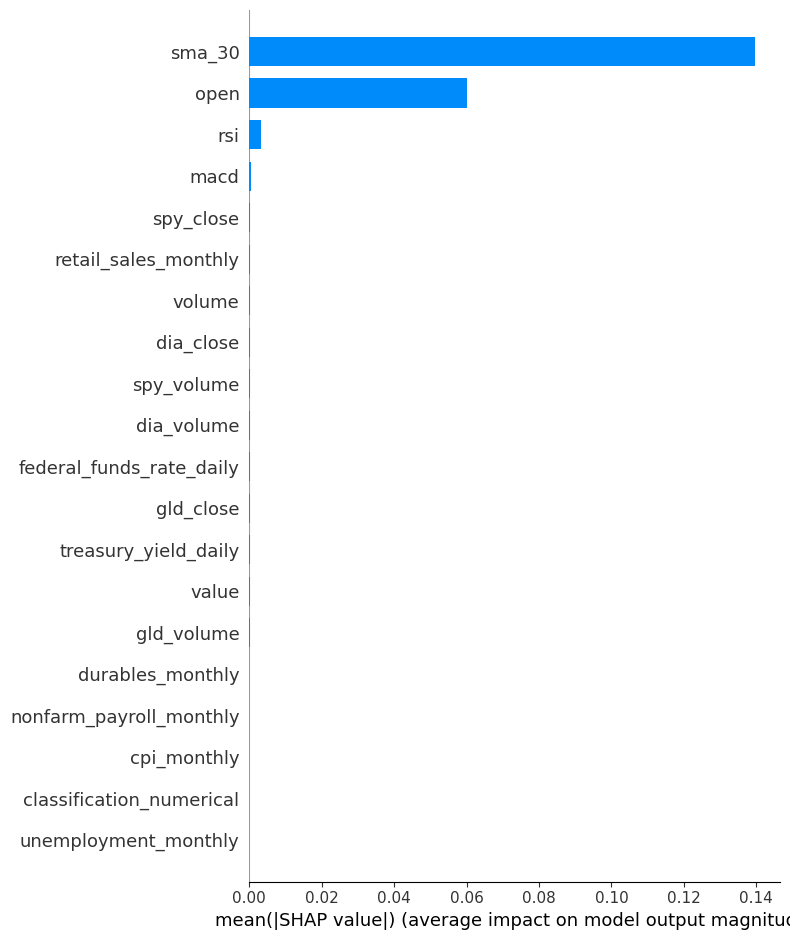

<Figure size 640x480 with 0 Axes>

In [10]:
import shap

# Initialize the SHAP explainer (tree explainer is efficient for tree-based models)
explainer = shap.TreeExplainer(model)

# Sample the numeric data
x_sample = shap.sample(x_train_scaled_df[x_train_numeric.columns], 100)  # Adjust the sample size as needed
shap_values = explainer.shap_values(x_sample)

# Summarize the effects of all the features
shap.summary_plot(shap_values, x_train_numeric, plot_type="bar")

# Save the figure
plot_path = os.path.join(plot_dir, 'shap_summary_plot.png')
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(plot_path, bbox_inches='tight')  # Save the current Matplotlib figure

plt.show()  # To display the plot in the notebook, if needed

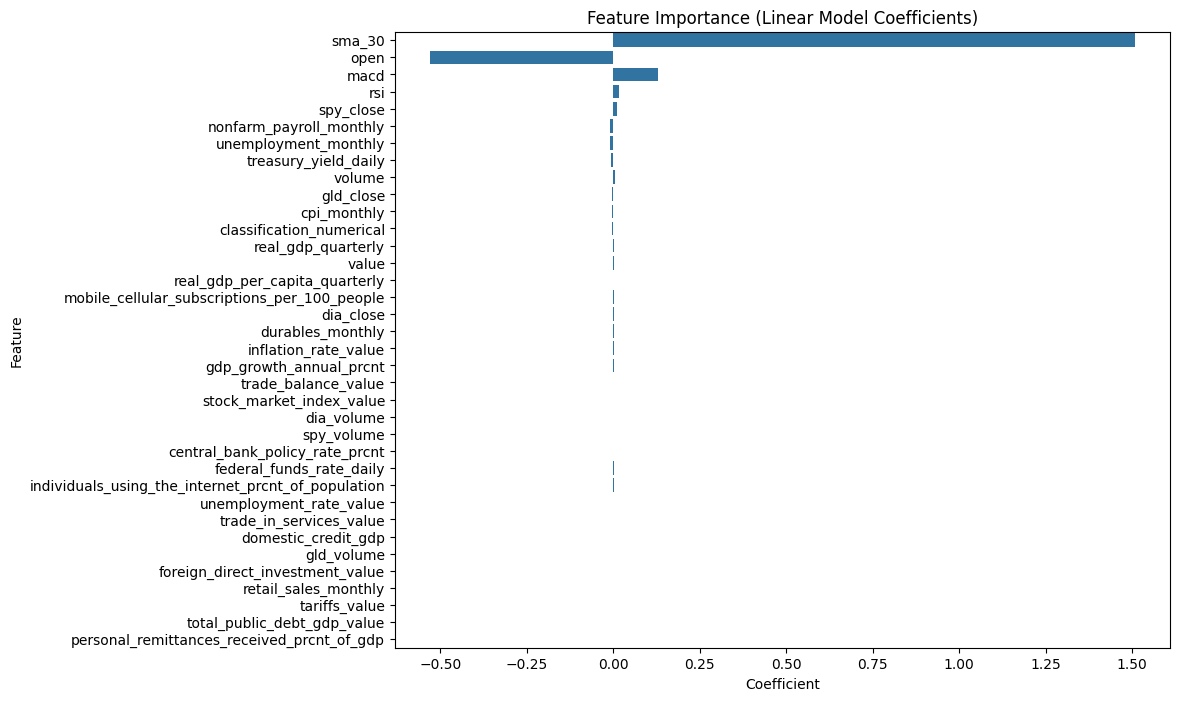

In [9]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Fit a linear model
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train_scaled)

# Coefficients as feature importance
coefficients = pd.DataFrame({'Feature': x_train_numeric.columns, 'Coefficient': linear_model.coef_})
coefficients['abs_coeff'] = coefficients['Coefficient'].abs()
coefficients.sort_values(by='abs_coeff', ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance (Linear Model Coefficients)')

# Save the figure
plot_path = os.path.join(plot_dir, 'linear_model_coefficients.png')
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(plot_path)

plt.show()
